In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import requests
import time
import math

The given script insert the weather and distance information for the selected year (2023 by default)

You need the following files correctly located:
* ../Data/2023_edges_header.csv
* ../Data/2023_edges.csv
* ../Data/2023_forecast_hourly.csv
* ../Data/2023_nodes_header.csv
* ../Data/2023_nodes.csv

And if you don't want to compute the distance using an API or harvesine only (recommended):
* ../Data/distances_df.csv 

The following script will produce the following outputs:
* ../Data/2023_edges_extended_header.csv
* ../Data/2023_edges_extended.csv

In the first cell bellow, you can choose if you want to compute the distance matrix ourself or use the provided one (see above).
If you want to compute the distance matrix, you can use either an API (open route service by default) or compute the haversine distance only.
To use the API, you need to provide an API key. /!\ Using the API may requires multiple days and runs given the restriction of your key.

!!! We don't recommend to launch this script but simply to use the provided output dataset.

In [2]:
LOAD_EXISTING_DISTANCE_DF = True
COMPUTE_HAVERSINE_ONY = False # It is used only if LOAD_EXISTING_DISTANCE_DF is False
API_KEY = "YOUR_API_KEY" # your ORS or Google API key 

In [3]:
with open('../Data/2023_edges_header.csv', 'r') as file:
    columns = file.readline().strip().split(',') 
df_edges = pd.read_csv('../Data/2023_edges.csv', header=None)
df_edges.columns = columns
df_edges

,:START_ID,starttimems:int,startlatitude:float,startlongitude:float,endtimems:int,endlatitude:float,endlongitude:float,:END_ID,start_date:DATETIME,end_date:DATETIME,:TYPE
0,0,1698266696468,45.524236,-73.581552,1698267092113,45.534134,-73.573524,505,2023-10-25T20:44:56.468000,2023-10-25T20:51:32.113000,CYCLES_TO
1,1,1698270535502,45.460156,-73.567001,1698271967951,45.501441,-73.560144,297,2023-10-25T21:48:55.502000,2023-10-25T22:12:47.951000,CYCLES_TO
2,2,1698285705974,45.498588,-73.574278,1698285992418,45.494200,-73.559985,467,2023-10-26T02:01:45.974000,2023-10-26T02:06:32.418000,CYCLES_TO
3,3,1698269489932,45.527432,-73.579917,1698269814383,45.519897,-73.580106,420,2023-10-25T21:31:29.932000,2023-10-25T21:36:54.383000,CYCLES_TO
4,4,1698270006571,45.510625,-73.566903,1698270440298,45.519581,-73.560116,1630,2023-10-25T21:40:06.571000,2023-10-25T21:47:20.298000,CYCLES_TO
...,...,...,...,...,...,...,...,...,...,...,...
11719680,408,1685820631664,45.504242,-73.553470,1685823750407,45.477605,-73.573775,528,2023-06-03T19:30:31.664000,2023-06-03T20:22:30.407000,CYCLES_TO
11719681,488,1685820631467,45.549598,-73.541874,1685821009127,45.559482,-73.535496,3321,2023-06-03T19:30:31.467000,2023-06-03T19:36:49.127000,CYCLES_TO
11719682,906,1685820628918,45.535190,-73.615482,1685822020021,45.527795,-73.571939,307,2023-06-03T19:30:28.918000,2023-06-03T19:53:40.021000,CYCLES_TO
11719683,1264,1685820635166,45.499965,-73.556154,1685822157916,45.475193,-73.580943,1778,2023-06-03T19:30:35.166000,2023-06-03T19:55:57.916000,CYCLES_TO


In [4]:
#from "weatherstats.ca based on Environment and Climate Change Canada data"
good_weather = [
    'Quelques nuages', 'Partiellement nuageux', 'Nuageux', 
    'Généralement nuageux. Risque de bruine verglaçante', 'Généralement nuageux', 
    'Généralement ensoleillé', 'Fumée', 'Ensoleillé', 'Dégagé', 
    'Couvert', 'Alternance de soleil et de nuages', 
    'Alternance de soleil et de nuages. Risque d\'orages'
]

df_weather = pd.read_csv('../Data/2023_forecast_hourly.csv')
df_weather['period_string'] = pd.to_datetime(df_weather['period_string'])
df_weather_2023 = df_weather[df_weather['period_string'].dt.year == 2023]
df_weather_2023.reset_index(drop=True, inplace=True)
df_weather_2023 = df_weather_2023[['period_string','conditions','temperature','wind_speed']]
df_weather_2023['good_weather'] = df_weather_2023['conditions'].apply(lambda x: 1 if x in good_weather else 0)
df_weather_2023.drop_duplicates(subset=['period_string'], keep='first', inplace=True)
df_weather_2023

,period_string,conditions,temperature,wind_speed,good_weather
0,2023-12-31 16:00:00,Possibilité d'averses de neige,-5,15,0
1,2023-12-31 17:00:00,Possibilité d'averses de neige,-5,15,0
2,2023-12-31 18:00:00,Possibilité d'averses de neige,-5,15,0
3,2023-12-31 19:00:00,Possibilité d'averses de neige,-5,15,0
4,2023-12-31 20:00:00,Possibilité d'averses de neige,-6,15,0
...,...,...,...,...,...
33940,2023-01-01 00:00:00,Pluie,4,10,0
33941,2023-01-01 01:00:00,Pluie,4,10,0
33942,2023-01-01 02:00:00,Pluie,4,10,0
33943,2023-01-01 03:00:00,Pluie,3,10,0


In [5]:
df_edges['start_date:DATETIME'] = pd.to_datetime(df_edges['start_date:DATETIME'])
df_edges['end_date:DATETIME'] = pd.to_datetime(df_edges['end_date:DATETIME'])
# Extract year, month, day, and hour from 'start_date:DATETIME' column in df_edges
df_edges['year'] = df_edges['start_date:DATETIME'].dt.year
df_edges['month'] = df_edges['start_date:DATETIME'].dt.month
df_edges['day'] = df_edges['start_date:DATETIME'].dt.day
df_edges['hour'] = df_edges['start_date:DATETIME'].dt.hour
df_edges['dayofWeek'] = df_edges['start_date:DATETIME'].dt.dayofweek

# Convert 'period_string' column in df_weather_2023 to datetime format
df_weather_2023['period_string'] = pd.to_datetime(df_weather_2023['period_string'])

# Merge df_edges and df_weather_2023 based on year, month, day, and hour
df_edges_weather = pd.merge(df_edges, df_weather_2023, 
                            left_on=['year', 'month', 'day', 'hour'], 
                            right_on=[df_weather_2023['period_string'].dt.year,
                                      df_weather_2023['period_string'].dt.month,
                                      df_weather_2023['period_string'].dt.day,
                                      df_weather_2023['period_string'].dt.hour], 
                            how='left')
df_edges_weather

,:START_ID,starttimems:int,startlatitude:float,startlongitude:float,endtimems:int,endlatitude:float,endlongitude:float,:END_ID,start_date:DATETIME,end_date:DATETIME,...,year,month,day,hour,dayofWeek,period_string,conditions,temperature,wind_speed,good_weather
0,0,1698266696468,45.524236,-73.581552,1698267092113,45.534134,-73.573524,505,2023-10-25 20:44:56.468,2023-10-25 20:51:32.113,...,2023,10,25,20,2,2023-10-25 20:00:00,Généralement nuageux,18.0,30.0,1.0
1,1,1698270535502,45.460156,-73.567001,1698271967951,45.501441,-73.560144,297,2023-10-25 21:48:55.502,2023-10-25 22:12:47.951,...,2023,10,25,21,2,2023-10-25 21:00:00,Généralement nuageux,18.0,15.0,1.0
2,2,1698285705974,45.498588,-73.574278,1698285992418,45.494200,-73.559985,467,2023-10-26 02:01:45.974,2023-10-26 02:06:32.418,...,2023,10,26,2,3,2023-10-26 02:00:00,Généralement nuageux,16.0,15.0,1.0
3,3,1698269489932,45.527432,-73.579917,1698269814383,45.519897,-73.580106,420,2023-10-25 21:31:29.932,2023-10-25 21:36:54.383,...,2023,10,25,21,2,2023-10-25 21:00:00,Généralement nuageux,18.0,15.0,1.0
4,4,1698270006571,45.510625,-73.566903,1698270440298,45.519581,-73.560116,1630,2023-10-25 21:40:06.571,2023-10-25 21:47:20.298,...,2023,10,25,21,2,2023-10-25 21:00:00,Généralement nuageux,18.0,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11719680,408,1685820631664,45.504242,-73.553470,1685823750407,45.477605,-73.573775,528,2023-06-03 19:30:31.664,2023-06-03 20:22:30.407,...,2023,6,3,19,5,2023-06-03 19:00:00,Ensoleillé,18.0,20.0,1.0
11719681,488,1685820631467,45.549598,-73.541874,1685821009127,45.559482,-73.535496,3321,2023-06-03 19:30:31.467,2023-06-03 19:36:49.127,...,2023,6,3,19,5,2023-06-03 19:00:00,Ensoleillé,18.0,20.0,1.0
11719682,906,1685820628918,45.535190,-73.615482,1685822020021,45.527795,-73.571939,307,2023-06-03 19:30:28.918,2023-06-03 19:53:40.021,...,2023,6,3,19,5,2023-06-03 19:00:00,Ensoleillé,18.0,20.0,1.0
11719683,1264,1685820635166,45.499965,-73.556154,1685822157916,45.475193,-73.580943,1778,2023-06-03 19:30:35.166,2023-06-03 19:55:57.916,...,2023,6,3,19,5,2023-06-03 19:00:00,Ensoleillé,18.0,20.0,1.0


In [6]:
with open('../Data/2023_nodes_header.csv', 'r') as file:
    columns = file.readline().strip().split(',') 
df_nodes = pd.read_csv('../Data/2023_nodes.csv', header=None)
df_nodes.columns = columns
df_nodes

,stationId:ID,name,latitude:float,longitude:float,:LABEL
0,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,Station
1,1,Rielle / Wellington,45.460156,-73.567001,Station
2,2,Ste-Catherine / Drummond,45.498588,-73.574278,Station
3,3,Boyer / du Mont-Royal,45.527432,-73.579917,Station
4,4,Clark / Ontario,45.510625,-73.566903,Station
...,...,...,...,...,...
934,2197094,Gilford / Drolet,45.523970,-73.585075,Station
935,4838893,Parc Père-Marquette ( de Bellechasse / de Lana...,45.539354,-73.595374,Station
936,4941087,Saint-Sylvestre / Labonté,45.535426,-73.513659,Station
937,11211239,Jardin Botanique (Sherbrooke / Pie-IX),45.556792,-73.554647,Station


In [7]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 1000 # to have the distance in meters

In [8]:


def compute_google_distances(origins, destinations, api_key):
    origins = (origins['latitude:float'].astype(str)+","+origins['longitude:float'].astype(str)).tolist()
    destinations = (destinations['latitude:float'].astype(str)+","+destinations['longitude:float'].astype(str)).tolist()

    url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    params = {
        "origins": "|".join(origins),
        "destinations": "|".join(destinations),
        "mode": "bicycling",
        "key": api_key
    }
    response = requests.get(url, params=params)
    
    data = response.json()
    return data

In [9]:
class ProxyError(Exception):
    pass

def compute_openrouteservice_distances(locations, api_key, retry_count = 3, retry_delay = 10):
    # print(locations)
    
    url = "https://api.openrouteservice.org/v2/matrix/cycling-regular"
    headers = {
        "Accept": "application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8",
        "Authorization": api_key
    }

    locations = [[row['longitude:float'], row['latitude:float']] for _, row in locations.iterrows()]
    
    body = {
        "locations": locations,
        "metrics": ["distance", "duration"],
        "units": "m"
    }


    for _ in range(retry_count):
        try:

            response = requests.post(url, json=body, headers=headers)
            print(response.text)
            data = response.json()
            if 'error' in data:
                raise ProxyError(data['error'])
        
            return data
        except ValueError:
            print("!!!!! One or more index labels not found. Retrying...")
            time.sleep(retry_delay)
        except ProxyError as e:
            print(f"!!!!! Proxy error encountered: {e}. Retrying...")
            time.sleep(retry_delay)

In [10]:
def create_partitions(input_list, max_size = 3):
    partitions = []
    memory = {key: set() for key in input_list}
    for anchor in input_list:
        
        temp = input_list.copy()
        temp.remove(anchor)
        
        while len(temp) > 0:
            partition = [anchor]
            assigned_nodes = []
            for node in temp:
                is_accepted = True

                if node in memory[anchor]:
                    # the anchor already know this node
                    assigned_nodes.append(node)
                for partition_node in partition:
                    if node in memory[partition_node]:
                        is_accepted = False
                        break
                
                if is_accepted:
                    partition.append(node)
                    assigned_nodes.append(node)
                    
                if len(partition) >= max_size:
                    break
            
            temp = [x for x in temp if x not in assigned_nodes]
            
            for partition_node in partition:
                memory[partition_node].update(partition)

            if len(partition) > 1: partitions.append(partition) # ignore partitions with only one node

    return partitions


# Toy example
# input_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# max_size = 3
# partitions = create_partitions(input_list, max_size=max_size)
# for partition in partitions:
#     print(partition)

In [11]:
def combine_partitions(partitions, max_size=3):
    combined_partitions = []
    current_partition = []

    for sublist in partitions:
        if len(current_partition) + len(sublist) <= max_size:
            current_partition.extend(sublist)
        else:
            combined_partitions.append(current_partition)
            current_partition = sublist[:]
    
    # Add the last combined sublist
    if current_partition:
        combined_partitions.append(current_partition)
    
    return combined_partitions

# Toy example
# input_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# partitions = create_partitions(input_list, max_size=4)
# print(partitions)
# print(len(partitions))
# partitions = combine_partitions(partitions, max_size=4)
# print(partitions)
# print(len(partitions))

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58], [0, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116], [0, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174], [0, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218

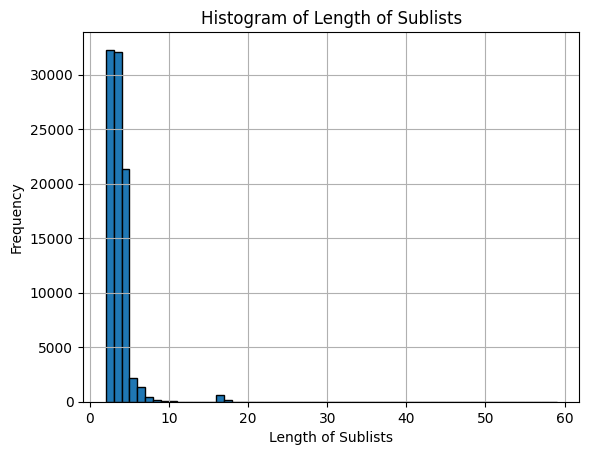

In [12]:
node_partitions = create_partitions(df_nodes.index.tolist(), max_size=59)
print(node_partitions)
print(len(node_partitions))

lengths = [len(sublist) for sublist in node_partitions]

# Plot the histogram
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 1), edgecolor='black')
plt.xlabel('Length of Sublists')
plt.ylabel('Frequency')
plt.title('Histogram of Length of Sublists')
plt.grid(True)
plt.show()

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58], [0, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116], [0, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174], [0, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218

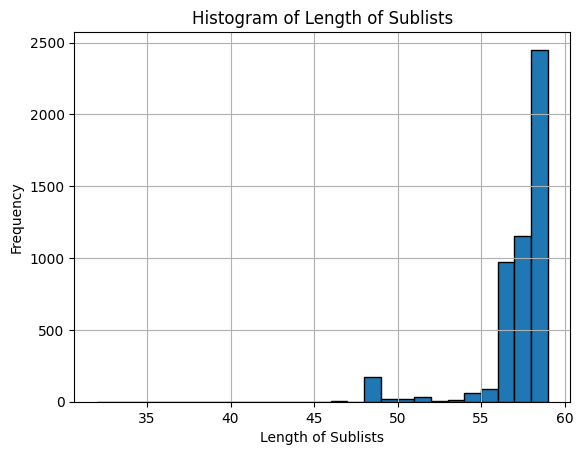

In [13]:
node_partitions = create_partitions(df_nodes.index.tolist(), max_size=59)
print(node_partitions)
combined_partitions = combine_partitions(node_partitions, max_size=59)
print(len(node_partitions), "vs.", len(combined_partitions))


lengths = [len(sublist) for sublist in combined_partitions]

# Plot the histogram
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 1), edgecolor='black')
plt.xlabel('Length of Sublists')
plt.ylabel('Frequency')
plt.title('Histogram of Length of Sublists')
plt.grid(True)
plt.show()

In [19]:
if LOAD_EXISTING_DISTANCE_DF:
    distances_df = pd.read_csv("../Data/distances_df.csv")
else:
    node_partitions = create_partitions(df_nodes.index.tolist(), max_size=59)
    combined_partitions = combine_partitions(node_partitions, max_size=59)

    try:
        with open("progress.txt", "r") as file:
            start_i = int(file.read())
    except FileNotFoundError:
        start_i = 0

    number_of_queries = 0
    max_number_of_queries = 2400

    all_results = []


    for i in range(start_i, len(combined_partitions)):
        partition = combined_partitions[i]
        partition_df = df_nodes.loc[partition]

        if len(partition_df) > 1:
            # by default, we use OpenRouteService API but the Google Maps API can be used as well, simply by changing the function name to compute_google_distances
            # you need to provide a valid key in API_KEY. Be carefull, Google Maps costs a lot! ;-)
            result = compute_openrouteservice_distances(partition_df[['latitude:float', 'longitude:float']], API_KEY)
            number_of_queries += 1
        else:
            result = {'distances': [[0]], 'durations': [[0]]}
        

        for j, idx1 in enumerate(partition):
            for k,idx2 in enumerate(partition):
                distance = result['distances'][j][k]
                duration = result['durations'][j][k]
                origin = partition_df.loc[idx1]
                destination = partition_df.loc[idx2]

                if isinstance(origin, pd.Series):
                    origin = pd.DataFrame([origin])
                if isinstance(destination, pd.Series):
                    destination = pd.DataFrame([destination])
                    
                all_results.append([origin.iloc[0]['stationId:ID'], origin.iloc[0]['name'], origin.iloc[0]['latitude:float'], origin.iloc[0]['longitude:float'],
                                    destination.iloc[0]['stationId:ID'], destination.iloc[0]['name'], destination.iloc[0]['latitude:float'], destination.iloc[0]['longitude:float'],
                                    distance, duration, -1])
        time.sleep(3)
        print(i / len(combined_partitions) * 100, "% (number of queries:", number_of_queries, ")")

        
        
        # Check if the number of queries has reached the limit
        if number_of_queries >= max_number_of_queries:
            with open("progress.txt", "w") as file:
                file.write(str(i))
            break

        
    distances_df = pd.DataFrame(all_results, columns=['origin_id', 'origin_name', 'origin_latitude', 'origin_longitude',
                                                    'destination_id', 'destination_name', 'destination_latitude', 'destination_longitude',
                                                    'distance_ors', 'duration_ors', 'distance_haversine'])

    distances_df.drop_duplicates(inplace=True)
    print(distances_df.shape)
    distances_df.head()

    try:
        existing_df = pd.read_csv("../Data/distances_df.csv")
    except FileNotFoundError:
        existing_df = pd.DataFrame()

    # Concatenate existing DataFrame with distances_df
    distances_df = pd.concat([existing_df, distances_df], ignore_index=True)

    # Drop duplicates
    distances_df.drop_duplicates(inplace=True)

    # Save the combined DataFrame to a new CSV file
    distances_df.to_csv("../Data/distances_df.csv", index=False)

In [20]:
distances_df.head()

,origin_id,origin_name,origin_latitude,origin_longitude,destination_id,destination_name,destination_latitude,destination_longitude,distance_ors,duration_ors,distance_haversine
0,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,0.00,0.00,-1
1,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,1,Rielle / Wellington,45.460156,-73.567001,10160.57,2061.49,-1
2,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,2,Ste-Catherine / Drummond,45.498588,-73.574278,4292.38,859.67,-1
3,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,3,Boyer / du Mont-Royal,45.527432,-73.579917,471.04,94.19,-1
4,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,4,Clark / Ontario,45.510625,-73.566903,2414.37,482.84,-1


In [ ]:
# distances_df.head()

# # for column in distances_df.columns:
# #     print(f'Column {column} has type: {distances_df[column].dtype}')

# # distances_df.drop_duplicates(inplace=True)
# print(distances_df.shape)
# distances_df.head()

# try:
#     existing_df = pd.read_csv("distances_df.csv")
# except FileNotFoundError:
#     existing_df = pd.DataFrame()

# # Concatenate existing DataFrame with distances_df
# combined_df = pd.concat([existing_df, distances_df], ignore_index=True)

# # Drop duplicates
# # combined_df.drop_duplicates(inplace=True)

# # Save the combined DataFrame to a new CSV file
# combined_df.to_csv("distances_df.csv", index=False)

(1383739, 11)


In [21]:

for id, row in distances_df.iterrows():
    dist_haversine = haversine(row['origin_latitude'],
                            row['origin_longitude'],
                            row['destination_latitude'],
                            row['destination_longitude'])
    distances_df['distance_haversine'][id] = dist_haversine
distances_df.head()

C:\Users\Chaubi\AppData\Local\Temp\ipykernel_15592\1492824091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distances_df['distance_haversine'][id] = dist_haversine
C:\Users\Chaubi\AppData\Local\Temp\ipykernel_15592\1492824091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distances_df['distance_haversine'][id] = dist_haversine
C:\Users\Chaubi\AppData\Local\Temp\ipykernel_15592\1492824091.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7215.101983863039' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

,origin_id,origin_name,origin_latitude,origin_longitude,destination_id,destination_name,destination_latitude,destination_longitude,distance_ors,duration_ors,distance_haversine
0,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,0.00,0.00,0.000000
1,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,1,Rielle / Wellington,45.460156,-73.567001,10160.57,2061.49,7215.101984
2,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,2,Ste-Catherine / Drummond,45.498588,-73.574278,4292.38,859.67,2907.664171
3,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,3,Boyer / du Mont-Royal,45.527432,-73.579917,471.04,94.19,377.509283
4,0,Métro Mont-Royal (Utilités publiques / Rivard),45.524236,-73.581552,4,Clark / Ontario,45.510625,-73.566903,2414.37,482.84,1895.637841


In [22]:
# haversine only ! to use if distance_df is not available and you want to compute the haversine distance "on the fly"
if not LOAD_EXISTING_DISTANCE_DF and COMPUTE_HAVERSINE_ONY:
    with open('../Data/2023_nodes_header.csv', 'r') as file:
        columns = file.readline().strip().split(',') 
    df_nodes = pd.read_csv('../Data/2023_nodes.csv', header=None)
    df_nodes.columns = columns
    df_nodes
    distances_df = [] 

    n = len(df_nodes)**2
    i = 0
    for idx1, station1 in df_nodes.iterrows():
        for idx2, station2 in df_nodes.iterrows():
            i += 1
            if idx1 != idx2:
                lon1, lat1 = station1['longitude:float'], station1['latitude:float']
                lon2, lat2 = station2['longitude:float'], station2['latitude:float']
                dist = haversine(lat1,lon1,lat2,lon2)
                arr = [station1['stationId:ID'], "", "", "", station2['stationId:ID'], "", "", "", -1, -1, dist]
 
                distances_df.append(arr)
                print(i/n*100, "%")

    distances_df = pd.DataFrame(distances_df, columns=['origin_id', 'origin_name', 'origin_latitude', 'origin_longitude',
                                                    'destination_id', 'destination_name', 'destination_latitude', 'destination_longitude',
                                                    'distance_ors', 'duration_ors', 'distance_haversine'])
    distances_df.head()

In [ ]:
# Used to skip the code above and store edges_extended without the ors distances

# df_edges_weather['distance_haversine'] = -1

# for id, row in df_edges_weather.iterrows():
#     dist_haversine = haversine(row['startlatitude:float'],
#                                row['startlongitude:float'],
#                                row['endlatitude:float'],
#                                row['endlongitude:float'])
#     df_edges_weather['distance_haversine'][id] = dist_haversine

# column_names = df_edges_weather.columns

# with open('../Data/2023_edges_extended_header.csv', 'w') as f:
#     f.write(','.join(column_names))

# df_edges_weather.to_csv('../Data/2023_edges_extended.csv',index=False, header=False)

# df_edges_weather.head()

In [ ]:
# # Create a dictionary to map node pairs to their distances
# node_pairs_to_distance_ors = {}
# node_pairs_to_distance_haversine = {}
# node_pairs_to_duration_ors = {}

# # Populate the dictionary with distances
# for id, distance in distances_df.iterrows():
#     # print(distance)
#     node1, _, _, _, node2, _, _, _, dist_ors, duration_ors, dist_haversine = distance
#     # Add distance for both directions of the edge
#     node_pairs_to_distance_ors[(node1, node2)] = dist_ors
#     node_pairs_to_distance_haversine[(node1, node2)] = dist_haversine
#     node_pairs_to_duration_ors[(node1, node2)] = duration_ors
#     # node_pairs_to_duration[(node2, node1)] = duration

# # Create a new column 'distance' in the edges DataFrame
# df_edges_weather['distance_in_meters_ors'] = [
#     node_pairs_to_distance_ors.get((start_node_id, end_node_id), None)
#     for start_node_id, end_node_id in zip(df_edges_weather[':START_ID'], df_edges_weather[':END_ID'])
# ]

# df_edges_weather['duration_in_seconds_ors'] = [
#     node_pairs_to_duration_ors.get((start_node_id, end_node_id), None)
#     for start_node_id, end_node_id in zip(df_edges_weather[':START_ID'], df_edges_weather[':END_ID'])
# ]

# df_edges_weather['distance_in_meters_haversine'] = [
#     node_pairs_to_distance_haversine.get((start_node_id, end_node_id), None)
#     for start_node_id, end_node_id in zip(df_edges_weather[':START_ID'], df_edges_weather[':END_ID'])
# ]

# # Now df_edges_weather contains a new column 'distance' with the distances for each edge
# df_edges_weather = df_edges_weather.drop(['period_string'],axis=1)
# df_edges_weather

In [23]:

mapped_df = df_edges_weather.merge(distances_df[['origin_id', 'destination_id', 'distance_ors', 'duration_ors', 'distance_haversine']], 
                                   left_on=[":START_ID", ":END_ID"], 
                                   right_on=["origin_id", "destination_id"], 
                                   how="left")

mapped_df.head()

,:START_ID,starttimems:int,startlatitude:float,startlongitude:float,endtimems:int,endlatitude:float,endlongitude:float,:END_ID,start_date:DATETIME,end_date:DATETIME,...,period_string,conditions,temperature,wind_speed,good_weather,origin_id,destination_id,distance_ors,duration_ors,distance_haversine
0,0,1698266696468,45.524236,-73.581552,1698267092113,45.534134,-73.573524,505,2023-10-25 20:44:56.468,2023-10-25 20:51:32.113,...,2023-10-25 20:00:00,Généralement nuageux,18.0,30.0,1.0,0,505,1370.14,277.86,1265.884488
1,1,1698270535502,45.460156,-73.567001,1698271967951,45.501441,-73.560144,297,2023-10-25 21:48:55.502,2023-10-25 22:12:47.951,...,2023-10-25 21:00:00,Généralement nuageux,18.0,15.0,1.0,1,297,6308.18,1301.75,4621.718528
2,2,1698285705974,45.498588,-73.574278,1698285992418,45.494200,-73.559985,467,2023-10-26 02:01:45.974,2023-10-26 02:06:32.418,...,2023-10-26 02:00:00,Généralement nuageux,16.0,15.0,1.0,2,467,1373.10,283.17,1216.274132
3,3,1698269489932,45.527432,-73.579917,1698269814383,45.519897,-73.580106,420,2023-10-25 21:31:29.932,2023-10-25 21:36:54.383,...,2023-10-25 21:00:00,Généralement nuageux,18.0,15.0,1.0,3,420,1217.88,245.38,838.028295
4,4,1698270006571,45.510625,-73.566903,1698270440298,45.519581,-73.560116,1630,2023-10-25 21:40:06.571,2023-10-25 21:47:20.298,...,2023-10-25 21:00:00,Généralement nuageux,18.0,15.0,1.0,4,1630,1504.53,320.23,1127.610237


In [24]:
# Tadaah! We have successfully mapped the weather and distances to the edges DataFrame.
column_names = mapped_df.columns

with open('../Data/2023_edges_extended_header.csv', 'w') as f:
    f.write(','.join(column_names))

mapped_df.to_csv('../Data/2023_edges_extended.csv',index=False, header=False)